# Agent Memory

**Agents** are LLMs that use tools and make decisions based on feedback, repeating this process in a loop.
Even though agents can handle complex tasks, the basic idea is simple: they take an action, see what happens, then decide what to do next. Because of this, it's important to design the tools they use and explain them clearly.

**When to use agents:**
Agents are helpful for open-ended tasks where you can't predict all the steps in advance or write a fixed set of instructions. They work well in situations where the LLM needs to make decisions on its own over many steps. This makes agents great for handling large or flexible tasks—especially in trusted environments where you can rely on their judgment.

## Agent Memory

Agent Memory refers to the ability of an AI agent to remember past interactions or conversation history. This allows the agent to carry on more natural and context-aware conversations, using previous messages to understand the user’s needs better, maintain continuity, and give more relevant responses over time.

## Prerequisite

- [Ollama](https://ollama.com/) installed to generate the graph
- Taviley search tool to retrieve context for our usecase.

Download the granite model

```sh
ollama pull granite3.2:2b  
```


In [ ]:
%%capture --no-stderr
## lets start with installing all the required libraries
%pip install --upgrade --quiet langgraph  langchain langchain-community langchain-ollama langchain-experimental python-dotenv langchain_core

In [1]:
## Load the environment variable from .env file

import os
from dotenv import load_dotenv
load_dotenv()

True

### LLM Model using OLLAMA

In [2]:
### LLM
from langchain_ollama import ChatOllama
from IPython.display import display

local_llm = "granite3.2:2b"
llm = ChatOllama(model=local_llm, temperature=0)

## Lets start with a basic conversation without memory

#### Define tools

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools)

In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

We use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

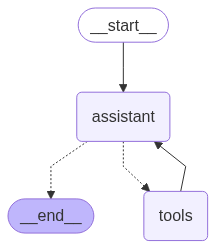

In [5]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})

In [7]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.

[
{"function": "add", "arguments": {"a": 3, "b": 4}}
]

result: 7


In [8]:
messages = [HumanMessage(content="Multiply that by 5")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 5
================================== Ai Message ==================================

To perform the multiplication, I will use the "multiply" function. Here's how it works:

1. The input is a pair of integers (a and b).
2. The multiply function takes these two integers as parameters.
3. It multiplies them together.
4. The result is returned.

Let's assume we have the following inputs for this operation:
- a = 7
- b = 3

Using the "multiply" function with these values, the calculation would be:
a * b = 7 * 3 = 21

So, if you want to multiply by 5, we need to apply the multiplication first and then multiply the result by 5. Here's how it goes:
- First, a * b = 21 (as calculated above).
- Then, 21 * 5 = 105

So, the final answer is 105.


#### Observe that the agent is halucinating and answering it wrong. It doesn't understand what to multiply by 5 because it doesn't have the previous memory.

## Lets implement memory

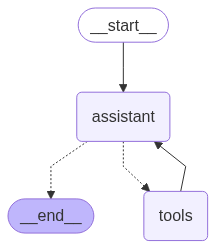

In [9]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

## We have to compile the graph again to let it know that we are using memory/checkpointer to retain history.
react_graph_memory = builder.compile(checkpointer=memory)
# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
# Specify a thread, you can think of it as a user id. You can access and store the history with this thread_id.

config = {"configurable": {"thread_id": "1"}}

In [11]:
# First conversation of thread_id: 1

messages = [HumanMessage(content="Add 5 and 8.")]
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 5 and 8.
================================== Ai Message ==================================

The result of adding 5 and 8 is 13.

[
{"function": "add", "arguments": {"a": 5, "b": 8}}
]

result: 13


In [12]:
messages = [HumanMessage(content="Multiply that by 100.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 5 and 8.
================================== Ai Message ==================================

The result of adding 5 and 8 is 13.

[
{"function": "add", "arguments": {"a": 5, "b": 8}}
]

result: 13
================================ Human Message =================================

Multiply that by 100.
================================== Ai Message ==================================

To multiply the result of adding 5 and 8 (which is 13) by 100, we get 1300.

 [
{"function": "multiply", "arguments": {"a": 13, "b": 100}}
]

 result: 1300


In [13]:
react_graph_memory.get_state(config).values["messages"]

[HumanMessage(content='Add 5 and 8.', additional_kwargs={}, response_metadata={}, id='4f545755-c0b9-48a7-837a-9f56819cef00'),
 AIMessage(content='The result of adding 5 and 8 is 13.\n\n[\n{"function": "add", "arguments": {"a": 5, "b": 8}}\n]\n\nresult: 13', additional_kwargs={}, response_metadata={'model': 'granite3.2:2b', 'created_at': '2025-05-22T23:18:02.132284Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7061768775, 'load_duration': 1287424463, 'prompt_eval_count': 211, 'prompt_eval_duration': 2938000000, 'eval_count': 49, 'eval_duration': 2716000000, 'model_name': 'granite3.2:2b'}, id='run--f65e67d7-343f-48f9-9f6a-b3cd2290d477-0', usage_metadata={'input_tokens': 211, 'output_tokens': 49, 'total_tokens': 260}),
 HumanMessage(content='Multiply that by 100.', additional_kwargs={}, response_metadata={}, id='0c7c3c05-92f8-4e1b-83fc-5898f31a2fa4'),
 AIMessage(content='To multiply the result of adding 5 and 8 (which is 13) by 100, we get 1300.\n\n [\n{"function": "multiply",